In [1]:
import numpy as np
import pandas as pd
import sklearn 
import imblearn 
from sklearn.metrics import classification_report, confusion_matrix
import math 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
taiwan_data = pd.read_csv('taiwan_data.csv')
print(taiwan_data)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0          20000    1          2         1          0      2      2     -1   
1         120000    1          2         2          0     -1      2      0   
2          90000    1          2         2          0      0      0      0   
3          50000    1          2         1          0      0      0      0   
4          50000    0          2         1          1     -1      0     -1   
...          ...  ...        ...       ...        ...    ...    ...    ...   
29995     220000    0          3         1          0      0      0      0   
29996     150000    0          3         2          0     -1     -1     -1   
29997      30000    0          2         2          0      4      3      2   
29998      80000    0          3         1          0      1     -1      0   
29999      50000    0          2         1          0      0      0      0   

       PAY_4  PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_

In [3]:
### set sensitive attribute equal to 'SEX' or 'Age Group' ###

sen_att = 'Age Group'

In [4]:
#split data in a test and train set

from sklearn.model_selection import train_test_split
X = taiwan_data.loc[:, taiwan_data.columns != 'Creditworthiness']
y = taiwan_data.loc[:, taiwan_data.columns == 'Creditworthiness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

#apply SMOTE to the trainingset
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Creditworthiness'])



In [5]:
os_data_X.shape

(37382, 23)

In [6]:
print(os_data_X)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0         420000    1          2         2          0      0      0      0   
1         230000    1          5         1          0     -1     -1     -1   
2          30000    1          2         1          0      2      2      2   
3          30000    1          2         1          1      2      2      2   
4         390000    1          1         1          0     -1      0     -1   
...          ...  ...        ...       ...        ...    ...    ...    ...   
37377      20000    1          3         1          0      1     -2     -2   
37378      10000    0          2         2          0      0      0      0   
37379     300000    0          1         1          0     -1     -1     -1   
37380      80000    0          2         2          0      2      2      2   
37381      20000    0          1         2          0     -1      0      0   

       PAY_4  PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL

In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier as a ranker 
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(os_data_X, os_data_y)

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
y_pred = knn.predict(os_data_X)


from sklearn.metrics import classification_report
print(classification_report(os_data_y, y_pred))




<ipython-input-8-cb4c76803ffd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(os_data_X, os_data_y)


              precision    recall  f1-score   support

           0       0.70      0.86      0.77     18691
           1       0.82      0.63      0.71     18691

    accuracy                           0.75     37382
   macro avg       0.76      0.75      0.74     37382
weighted avg       0.76      0.75      0.74     37382



In [9]:
matrix = sklearn.metrics.confusion_matrix(os_data_y, y_pred)
sklearn.metrics.accuracy_score(os_data_y, y_pred)
print(matrix)

[[16138  2553]
 [ 6889 11802]]


In [10]:
### append the ranker results to the dataset ####

result = pd.concat([os_data_X, os_data_y.reindex(os_data_X.index)], axis=1)
prob  = knn.predict_proba(os_data_X)[:,1]


result['prob'] = prob
print(result)
#df_test = [os_data_X, os_data_y, df_prob]


       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0         420000    1          2         2          0      0      0      0   
1         230000    1          5         1          0     -1     -1     -1   
2          30000    1          2         1          0      2      2      2   
3          30000    1          2         1          1      2      2      2   
4         390000    1          1         1          0     -1      0     -1   
...          ...  ...        ...       ...        ...    ...    ...    ...   
37377      20000    1          3         1          0      1     -2     -2   
37378      10000    0          2         2          0      0      0      0   
37379     300000    0          1         1          0     -1     -1     -1   
37380      80000    0          2         2          0      2      2      2   
37381      20000    0          1         2          0     -1      0      0   

       PAY_4  PAY_5  ...  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_A

In [11]:
## building the discrimination formula: 

def disc(df, S, y, sv, nv):
    sum_sen_neg = 0
    sum_sen_pos = 0
    sum_non_neg = 0
    sum_non_pos = 0

    for row in range(len(df)) :
        if df.at[row, S] == sv and df.at[row, y] == 0:
            sum_sen_neg +=1
        elif df.at[row, S] == sv and df.at[row, y] == 1: 
            sum_sen_pos += 1
        elif df.at[row, S] == nv and df.at[row, y] == 0: 
            sum_non_neg += 1
        else:
            sum_non_pos += 1
        #print(sum_non_neg, sum_non_pos)
    
    sum_sen = sum_sen_neg + sum_sen_pos
    sum_non = sum_non_neg + sum_non_pos
    
    disc_val = (abs(sum_non_pos/sum_non)-abs(sum_sen_pos/sum_sen)) 
    print(sum_non_pos/sum_non)
    print(sum_sen_pos/sum_sen)
    print("women neg",sum_sen_neg,"women pos", sum_sen_pos, "men neg", sum_non_neg,  "men pos",sum_non_pos)
    return disc_val

#TEST
disc(result, sen_att, 'Creditworthiness', 0, 1)


0.6932114882506527
0.4873446585338046
women neg 17986 women pos 17098 men neg 705 men pos 1593


0.2058668297168481

In [12]:
#sensitive value counts 

def count_s_val(df, S, v):
    count = 0
    for row in range(len(df)):
        if df.at[row, S] == v: 
            count += 1
        else:
            pass
    return count 

men_count = count_s_val(result, sen_att, 0)    
print ('Men count',men_count)

#define size of values for massaging M

M = math.ceil(((disc(result, sen_att, 'Creditworthiness', 0, 1)) * (count_s_val(result, sen_att, 0)) *  (count_s_val(result, sen_att, 1)))/((count_s_val(result, sen_att, 0)) +  (count_s_val(result, sen_att, 1))))
print(M)

Men count 35084
0.6932114882506527
0.4873446585338046
women neg 17986 women pos 17098 men neg 705 men pos 1593
444


In [13]:
# organise the results in descending order 
result_sorted = result.sort_values(by=[sen_att, 'prob'], ascending=[True, False], ignore_index=True)
result_sorted

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,Age Group,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Creditworthiness,prob
0,230000,1,5,1,0,-1,-1,-1,-1,-2,...,-2900,-2900,0,8100,0,0,0,110256,1,1.0
1,610000,1,1,2,0,0,0,0,0,0,...,105301,105965,6540,2100,2150,50000,4700,2000,1,1.0
2,320000,1,2,2,0,-1,-1,-1,-1,-1,...,2655,1070,2610,9439,2493,2655,0,5682,1,1.0
3,20000,1,3,2,0,-1,-1,-1,0,0,...,18430,400,1165,19325,386,369,400,5125,1,1.0
4,170000,0,2,1,0,0,0,0,0,0,...,0,51269,1675,1500,1007,0,51269,1865,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37377,70000,0,2,1,1,2,2,2,2,2,...,45222,46146,2027,2000,1827,1827,1800,1754,0,0.0
37378,50000,0,2,1,1,2,0,0,2,1,...,13592,13362,1582,1879,120,1175,120,555,0,0.0
37379,30000,0,1,1,1,0,0,0,0,-1,...,-300,-300,1395,1343,524,0,0,0,0,0.0
37380,50000,0,2,2,1,0,0,0,0,0,...,18151,19463,2221,2015,904,727,2018,672,0,0.0


In [14]:
### applying massaging for the minorty class to transform to a positive output 

i = 0
for row in range(len(result_sorted)):
    
    if i <= M and result_sorted.at[row, sen_att] == 0 and result_sorted.at[row, "Creditworthiness"] == 0:
        result_sorted.at[row, 'Creditworthiness'] = 1 
        i += 1
    else:
        pass 
print (i)

print (result_sorted)

445
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0         230000    1          5         1          0     -1     -1     -1   
1         610000    1          1         2          0      0      0      0   
2         320000    1          2         2          0     -1     -1     -1   
3          20000    1          3         2          0     -1     -1     -1   
4         170000    0          2         1          0      0      0      0   
...          ...  ...        ...       ...        ...    ...    ...    ...   
37377      70000    0          2         1          1      2      2      2   
37378      50000    0          2         1          1      2      0      0   
37379      30000    0          1         1          1      0      0      0   
37380      50000    0          2         2          1      0      0      0   
37381      30000    0          3         1          1      1      2      3   

       PAY_4  PAY_5  ...  BILL_AMT5  BILL_AMT6  PAY_AMT1  P

In [15]:
## resorting the dataset to change the unportected group to a negative classification


result_sorted_2 = result_sorted.sort_values(by=[sen_att, 'prob'], ascending=[False, True], ignore_index=True)
print(result_sorted_2)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0          20000    1          3         2          1      2      0      0   
1          10000    1          3         1          1      2      2     -2   
2          80000    0          2         1          1      0      0      0   
3          30000    1          3         1          1      3      2      2   
4          30000    1          3         1          1      2      2      2   
...          ...  ...        ...       ...        ...    ...    ...    ...   
37377      90000    1          2         2          0     -2     -2     -2   
37378     280000    1          2         2          0     -2     -2     -1   
37379     280000    1          2         2          0      0      0      2   
37380     280000    1          2         1          0      2      2      2   
37381     360000    1          1         2          0     -1     -1     -1   

       PAY_4  PAY_5  ...  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_A

In [16]:
## sorting to create negative values for the unprotected group

i = 0
for row in range(len(result_sorted_2)):
    
    if i <= M and result_sorted_2.at[row, sen_att] == 1 and result_sorted_2.at[row, "Creditworthiness"] == 1:
        result_sorted_2.at[row, 'Creditworthiness'] = 0 
        i += 1
    else:
        pass 
print (i)

print (result_sorted_2)

445
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
0          20000    1          3         2          1      2      0      0   
1          10000    1          3         1          1      2      2     -2   
2          80000    0          2         1          1      0      0      0   
3          30000    1          3         1          1      3      2      2   
4          30000    1          3         1          1      2      2      2   
...          ...  ...        ...       ...        ...    ...    ...    ...   
37377      90000    1          2         2          0     -2     -2     -2   
37378     280000    1          2         2          0     -2     -2     -1   
37379     280000    1          2         2          0      0      0      2   
37380     280000    1          2         1          0      2      2      2   
37381     360000    1          1         2          0     -1     -1     -1   

       PAY_4  PAY_5  ...  BILL_AMT5  BILL_AMT6  PAY_AMT1  P

### visualisations of what happens to the data

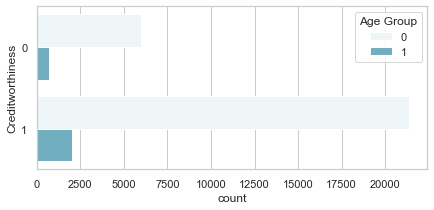

In [17]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Creditworthiness', hue =sen_att, data=taiwan_data, color="c")

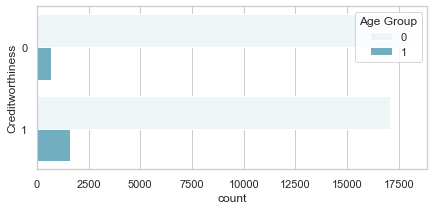

In [18]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Creditworthiness', hue =sen_att, data=result, color="c")

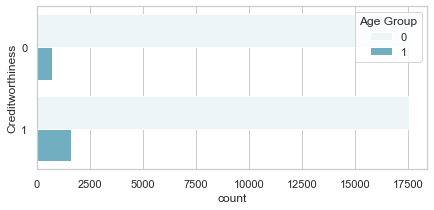

In [19]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Creditworthiness', hue =sen_att, data=result_sorted, color="c")

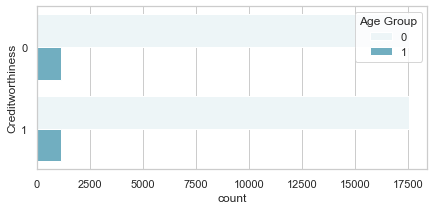

In [20]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Creditworthiness', hue =sen_att, data=result_sorted_2, color="c")

In [21]:
print(X_train)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
28010     420000    1          2         2          0      0      0      0   
5168      230000    1          5         1          0     -1     -1     -1   
4569       30000    1          2         1          0      2      2      2   
20281      30000    1          2         1          1      2      2      2   
19871     390000    1          1         1          0     -1      0     -1   
...          ...  ...        ...       ...        ...    ...    ...    ...   
11602      10000    0          1         1          1      0      0      0   
7625       20000    1          3         3          0      0      0      0   
17291      50000    1          2         2          0      0      0      0   
5831      140000    0          1         1          0      2      2      2   
9324       80000    1          1         1          0     -1     -1     -1   

       PAY_4  PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL

In [22]:
X_test.shape
X_train.shape
print(X_train)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  Age Group  PAY_0  PAY_2  PAY_3  \
28010     420000    1          2         2          0      0      0      0   
5168      230000    1          5         1          0     -1     -1     -1   
4569       30000    1          2         1          0      2      2      2   
20281      30000    1          2         1          1      2      2      2   
19871     390000    1          1         1          0     -1      0     -1   
...          ...  ...        ...       ...        ...    ...    ...    ...   
11602      10000    0          1         1          1      0      0      0   
7625       20000    1          3         3          0      0      0      0   
17291      50000    1          2         2          0      0      0      0   
5831      140000    0          1         1          0      2      2      2   
9324       80000    1          1         1          0     -1     -1     -1   

       PAY_4  PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler


X_train = result_sorted_2.loc[:, result_sorted_2.columns != 'Creditworthiness']
y_train = result_sorted_2.loc[:, result_sorted_2.columns =='Creditworthiness']

del X_train["prob"]

y_train =y_train.to_numpy()

y_train = y_train.ravel()

logit = LogisticRegression(penalty='l2', solver = 'liblinear', max_iter = 5000)
#logit = LogisticRegression()
logit.fit(X_train, y_train)


X_test.shape

(6000, 23)

In [24]:

y_pred =  logit.predict(X_test)


from sklearn.metrics import classification_report


matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(matrix)

[[ 446  881]
 [ 981 3692]]


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.34      0.32      1327
           1       0.81      0.79      0.80      4673

    accuracy                           0.69      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.70      0.69      0.69      6000



In [26]:
privileged_groups = [{sen_att: 0}]
unprivileged_groups = [{sen_att: 1}]
cost_constraint = "fnr"
randseed = 12345679 

In [27]:
fair_test_df = pd.concat([X_test, y_test], axis=1, join="inner")

In [28]:
# Metrics function
from collections import OrderedDict
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(fair_test_df, 
                          label_name='Creditworthiness', 
                          favorable_classes=[1], 
                          protected_attribute_names=[sen_att], 
                          privileged_classes=[[0]])

def fair_metrics(dataset, y_pred, disp = True):
    dataset_pred =dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric_pred = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
        
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))


fair_metrics(dataset, y_pred)

Balanced accuracy = 0.5631
Statistical parity difference = -0.0466
Disparate impact = 0.9392
Average odds difference = -0.0254
Equal opportunity difference = -0.0593
Theil index = 0.2238
